# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [7]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizerFast, BertForMaskedLM

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

/data/fx/wuli/anaconda3/envs/mllm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.5833333333333334

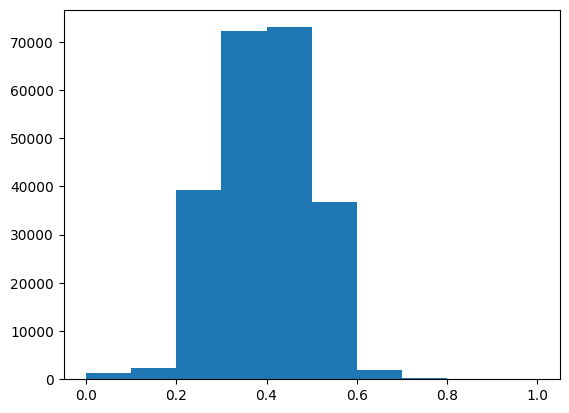

In [8]:
vowels = ['a', 'e', 'i', 'o', 'u']

full_dictionary_location = "words_250000_train.txt"

def p_vowel(s:str):
    return sum(c in vowels for c in s)/len(s)

text_file = open(full_dictionary_location,"r")
full_dictionary = text_file.read().splitlines()
text_file.close()

df = pd.Series([p_vowel(_) for _ in full_dictionary])
plt.hist(df)

p = 0.98
p_quantile = df.quantile(p)
p_quantile

In [39]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        self.tailed_letters = []
        self.blocking_bert = False
        self.acc_bert = 0
        
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)    
        self.sub_dictionary = self.build_dictionary_sub(full_dictionary_location)
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = BertTokenizerFast.from_pretrained('/archive/share/cql/trex/bert_hangman_tokenizer_random_epoch_18')
        self.model = BertForMaskedLM.from_pretrained('/archive/share/cql/trex/bert_hangman_model_random_epoch_18')
        self.model.to(self.device)
        
        self.current_dictionary = []
        
    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link

    def guess(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")
        
        # find length of passed word
        len_word = len(clean_word)
        
        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.current_dictionary
        new_dictionary = []
        
        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue
                
            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                # out the false match( . 2 guessed_letter)
                for c,d in zip(clean_word,dict_word):
                    if len_word>5 and c=='.' and d in self.guessed_letters and d not in self.tailed_letters:
                        break
                else:
                    new_dictionary.append(dict_word)
        
        # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary
        
        # sub-word dictionary
        new_sub_dictionary = []
        # iterate through all of the words in the old plausible dictionary
        for dict_word in self.sub_dictionary[len_word]:             
            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                new_sub_dictionary.append(dict_word)
                
        
        # # count occurrence of all characters in possible word matches
        # full_dict_string = "".join(new_dictionary)
        
        # c = collections.Counter(full_dict_string)
        # sorted_letter_count = c.most_common()           
        
        c = collections.Counter()
        for _ in new_dictionary:
            s = set(_)
            c += collections.Counter(s)
        sorted_letter_count = c.most_common()
            
        
        guess_letter = '!'
        
        print("self.acc_bert",self.acc_bert)
        
        if guess_letter == '!' and self.acc_bert<2 and (clean_word.count('.')/len_word<=1/4 or (len_word<=6 and clean_word.count('.')/len_word<=1/2)):
            # bert model here
            bert_input = clean_word.replace('.', self.tokenizer.mask_token)
            inputs = self.tokenizer(bert_input, return_tensors='pt')
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            self.model.eval()
            with torch.no_grad():
                outputs = self.model(**inputs)
                predictions = outputs.logits

            mask_token_indices = (inputs['input_ids'][0] == self.tokenizer.mask_token_id).nonzero(as_tuple=False)
            
            letter_probs = {}
            
            for idx in mask_token_indices:
                idx = idx.item()
                probs = torch.softmax(predictions[0, idx], dim=-1)
                topk = 5  # Adjust
                top_probs, top_indices = torch.topk(probs, topk)
                for prob, token_idx in zip(top_probs, top_indices):
                    predicted_token = self.tokenizer.convert_ids_to_tokens(token_idx.item())
                    if (predicted_token.isalpha() and predicted_token.islower()
                        and predicted_token not in self.guessed_letters):
                        letter_probs[predicted_token] = prob.item()
            
            if letter_probs:
                sorted_letters = sorted(letter_probs.items(), key=lambda x: x[1], reverse=True)
                for letter, prob in sorted_letters:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        self.blocking_bert = True
                        print("bert handling!")
                        return guess_letter
        
        # return most frequently occurring letter in all possible words that hasn't been guessed yet
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                if letter in vowels and p_vowel(clean_word)>p_quantile:
                    self.guessed_letters.append(letter)
                    self.tailed_letters.append(letter)
                    continue
                guess_letter = letter
                return guess_letter
            
        c = collections.Counter()
        for _ in new_sub_dictionary:
            s = set(_)
            c += collections.Counter(s)
        sorted_letter_count = c.most_common()
        
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                if letter in vowels and p_vowel(clean_word)>p_quantile:
                    self.guessed_letters.append(letter)
                    self.tailed_letters.append(letter)
                    continue
                guess_letter = letter
                return guess_letter
            
        # sub-word dictionary
        new_sub_dictionary_2 = []
        # iterate through all of the words in the old plausible dictionary
        l = len_word//2
        for dict_word in self.sub_dictionary[l]:             
            # if dictionary word is a possible match then add it to the current dictionary
            for start in range(len_word-l+1):
                if re.match(clean_word[start:start+l],dict_word):
                    new_sub_dictionary_2.append(dict_word)
            
        c = collections.Counter()
        for _ in new_sub_dictionary_2:
            s = set(_)
            c += collections.Counter(s)
        sorted_letter_count = c.most_common()
        
        for letter,instance_count in sorted_letter_count:
            # re-entry for exceptional vowels  
            if letter not in self.guessed_letters or letter in self.tailed_letters:
                guess_letter = letter
                return guess_letter
            
        # sub-word dictionary
        new_sub_dictionary_3 = []
        # iterate through all of the words in the old plausible dictionary
        l = len_word//3
        for dict_word in self.sub_dictionary[l]:             
            # if dictionary word is a possible match then add it to the current dictionary
            for start in range(len_word-l+1):
                if re.match(clean_word[start:start+l],dict_word):
                    new_sub_dictionary_3.append(dict_word)
                
            
        c = collections.Counter()
        for _ in new_sub_dictionary_3:
            s = set(_)
            c += collections.Counter(s)
        sorted_letter_count = c.most_common()
        
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                guess_letter = letter
                return guess_letter
            
        # sub-word dictionary
        new_sub_dictionary_4 = []
        # iterate through all of the words in the old plausible dictionary
        l = len_word//4
        for dict_word in self.sub_dictionary[l]:             
            # if dictionary word is a possible match then add it to the current dictionary
            for start in range(len_word-l+1):
                if re.match(clean_word[start:start+l],dict_word):
                    new_sub_dictionary_4.append(dict_word)
            
        c = collections.Counter()
        for _ in new_sub_dictionary_4:
            s = set(_)
            c += collections.Counter(s)
        sorted_letter_count = c.most_common()
        
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                guess_letter = letter
                return guess_letter
            
        
            
        # if no word matches in training dictionary, default back to ordering of full dictionary
        sorted_letter_count = self.full_dictionary_common_letter_sorted
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                guess_letter = letter
                return guess_letter            
        
        return 'e'

    
    
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
    
    def build_dictionary_sub(self, dictionary_file_location):
        from collections import defaultdict
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        sub_dictionary = defaultdict(list)
        for word in full_dictionary:
            for l in range(1,len(word)):
                for start in range(len(word)-l+1):
                    sub_dictionary[l].append(word[start:start+l])
        return sub_dictionary
        
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.tailed_letters = []
        self.acc_bert = 0
        self.current_dictionary = self.full_dictionary
        last_tries_remains = 6
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                self.blocking_bert = False
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if tries_remains<last_tries_remains:
                    if self.blocking_bert:
                        self.acc_bert+=1
                    last_tries_remains = tries_remains
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [40]:
api = HangmanAPI(access_token="xxxx", timeout=2000)


## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [41]:
from tqdm import tqdm
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status()
last_succ = total_practice_successes
acc = 0
N=100
for _ in tqdm(range(N)):
    api.start_game(practice=1,verbose=True)
    [total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status()
    if total_practice_successes>last_succ:
        acc+=1
    last_succ = total_practice_successes
    print("Now acc:",acc/(_+1))
print(acc/N)
    
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))


  0%|          | 0/100 [00:00<?, ?it/s]

Successfully start a new game! Game ID: 7927ee6bb27b. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '7927ee6bb27b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e e _ e _ _ _ e _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '7927ee6bb27b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e e _ e _ _ _ e n _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '7927ee6bb27b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e e _ e _ _ _ e n _ '}
self.acc_bert 0
Guessing letter: f
Sever response: {'game_id': '7927ee6bb27b', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ e e _ e _ _ _ e n _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '7927ee6bb27b', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ e e _ e _ _ _ e n _ '}
self.acc_bert 0
Guessing letter: v
Sever response: {'game_id': '7927ee6bb27b', 'status': 'ongoing', 'tries_remains': 2, '

  1%|          | 1/100 [00:06<10:42,  6.49s/it]

Now acc: 0.0
Successfully start a new game! Game ID: 2abf03dde583. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '2abf03dde583', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '2abf03dde583', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ _ _ a _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '2abf03dde583', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ _ i a _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '2abf03dde583', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ _ i a n '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '2abf03dde583', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a r _ _ i a n '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '2abf03dde583', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a r _ _ i a n

  2%|▏         | 2/100 [00:16<14:10,  8.68s/it]

Now acc: 0.0
Successfully start a new game! Game ID: e36008233ad1. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'e36008233ad1', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'e36008233ad1', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ i _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'e36008233ad1', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ a _ i _ a _ i _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'e36008233ad1', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ a _ i t a t i _ _ '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': 'e36008233ad1', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ a g i t a t i _ _ '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'e36008233ad1', 'status': 'ongoing', 'tries_r

  3%|▎         | 3/100 [00:38<23:33, 14.58s/it]

Now acc: 0.0
Successfully start a new game! Game ID: 539951c8483b. # of tries remaining: 6. Word: _ _ _ _ _ .
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '539951c8483b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '539951c8483b', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '539951c8483b', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '539951c8483b', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ r _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '539951c8483b', 'status': 'ongoing', 'tries_remains': 3, 'word': 'i r _ i _ '}
self.acc_bert 0
bert handling!
Guessing letter: n
Sever response: {'game_id': '539951c8483b', 'status': 'ongoing', 'tries_remains': 2, 'word': 'i r _ i _ '}
self.acc_bert 1
bert ha

  4%|▍         | 4/100 [00:51<22:32, 14.08s/it]

Now acc: 0.25
Successfully start a new game! Game ID: 76e4814ec4ea. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '76e4814ec4ea', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '76e4814ec4ea', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ _ e _ i _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '76e4814ec4ea', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ o o _ _ _ _ _ _ _ e _ i _ _ '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': '76e4814ec4ea', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ o o _ _ _ _ _ _ _ e _ i _ g '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '76e4814ec4ea', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ o o _ _ _ _ a _ _ e _ i _ g '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_i

  5%|▌         | 5/100 [01:23<32:22, 20.45s/it]

Now acc: 0.4
Successfully start a new game! Game ID: 25969e6a86c3. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '25969e6a86c3', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ e _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '25969e6a86c3', 'status': 'ongoing', 'tries_remains': 6, 'word': 's _ _ _ e _ _ e s s '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '25969e6a86c3', 'status': 'ongoing', 'tries_remains': 6, 'word': 's _ _ _ e _ n e s s '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '25969e6a86c3', 'status': 'ongoing', 'tries_remains': 5, 'word': 's _ _ _ e _ n e s s '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '25969e6a86c3', 'status': 'ongoing', 'tries_remains': 4, 'word': 's _ _ _ e _ n e s s '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '25969e6a86c3', 'status': 'ongoing', 'tries_remains': 3, 

  6%|▌         | 6/100 [01:48<34:35, 22.08s/it]

Now acc: 0.3333333333333333
Successfully start a new game! Game ID: a930e9f04f0c. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'a930e9f04f0c', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'a930e9f04f0c', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'a930e9f04f0c', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ t e _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'a930e9f04f0c', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ u _ t e _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'a930e9f04f0c', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ u n t e _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'a930e

  7%|▋         | 7/100 [01:57<27:40, 17.86s/it]

Now acc: 0.42857142857142855
Successfully start a new game! Game ID: abf08f659172. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'abf08f659172', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'abf08f659172', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ _ _ e _ _ _ _ e _ _ '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'abf08f659172', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ _ _ e _ u _ _ e _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'abf08f659172', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ _ _ e _ u _ n e _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'abf08f659172', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ _ _ e _ u _ n e s s '}
self.acc_bert 0
Guessing letter: o
Sever res

  8%|▊         | 8/100 [02:22<30:38, 19.98s/it]

Now acc: 0.5
Successfully start a new game! Game ID: dd834bb34701. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'dd834bb34701', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'dd834bb34701', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'dd834bb34701', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ s _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'dd834bb34701', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ s _ e _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'dd834bb34701', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ s _ e n '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'dd834bb34701', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ s _ e n '}
self.acc_b

  9%|▉         | 9/100 [02:33<25:57, 17.11s/it]

Now acc: 0.4444444444444444
Successfully start a new game! Game ID: 4a12f52a27e7. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '4a12f52a27e7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '4a12f52a27e7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '4a12f52a27e7', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ e _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '4a12f52a27e7', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ e _ _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '4a12f52a27e7', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ e _ _ _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '4a12f52a27e7', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ l e _ _ _ '}
self.acc_

 10%|█         | 10/100 [02:43<22:39, 15.10s/it]

Now acc: 0.4
Successfully start a new game! Game ID: b30f363df4c4. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'b30f363df4c4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'b30f363df4c4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'b30f363df4c4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ n _ _ _ _ _ i _ n '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'b30f363df4c4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ n _ _ _ _ _ i o n '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'b30f363df4c4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ n u _ u _ _ i o n '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'b30f363df4c4', 'status': 'ongoing', 'tries_r

 11%|█         | 11/100 [03:10<27:32, 18.57s/it]

Now acc: 0.45454545454545453
Successfully start a new game! Game ID: a2d324656f36. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'a2d324656f36', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'a2d324656f36', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e s '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'a2d324656f36', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ e s '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'a2d324656f36', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ _ _ e s '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'a2d324656f36', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ o _ _ e s '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'a2d324656f36', 'status': 'ongoing', 'tries_remains': 4, 'word': 

 12%|█▏        | 12/100 [03:34<29:39, 20.22s/it]

Now acc: 0.4166666666666667
Successfully start a new game! Game ID: d4eb1fe66144. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'd4eb1fe66144', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'd4eb1fe66144', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': 'd4eb1fe66144', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e l l l _ _ _ e d '}
self.acc_bert 0
Guessing letter: w
Sever response: {'game_id': 'd4eb1fe66144', 'status': 'ongoing', 'tries_remains': 6, 'word': 'w e l l l _ _ _ e d '}
self.acc_bert 0
Guessing letter: k
Sever response: {'game_id': 'd4eb1fe66144', 'status': 'ongoing', 'tries_remains': 5, 'word': 'w e l l l _ _ _ e d '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': 'd4eb1fe66144', 'status': 'ongoing', 'trie

 13%|█▎        | 13/100 [03:59<31:44, 21.89s/it]

Now acc: 0.46153846153846156
Successfully start a new game! Game ID: abe8f16bb229. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'abe8f16bb229', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'abe8f16bb229', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'abe8f16bb229', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ i _ e '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'abe8f16bb229', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o _ _ o i _ e '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'abe8f16bb229', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ _ o i _ e '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': 'abe8f16bb229', 'status': 'ongoing', 'tries_remains': 3, 'word': 

 14%|█▍        | 14/100 [04:11<26:47, 18.69s/it]

Now acc: 0.42857142857142855
Successfully start a new game! Game ID: 9bc4b7cd011b. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '9bc4b7cd011b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '9bc4b7cd011b', 'status': 'ongoing', 'tries_remains': 6, 'word': 'a _ _ a _ _ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '9bc4b7cd011b', 'status': 'ongoing', 'tries_remains': 6, 'word': 'a _ _ a s _ _ e s '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '9bc4b7cd011b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ a s _ _ e s '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '9bc4b7cd011b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ a s _ t e s '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '9bc4b7cd011b', 'status': 'ongoing', 'tries_remains':

 15%|█▌        | 15/100 [04:46<33:43, 23.80s/it]

Now acc: 0.4
Successfully start a new game! Game ID: 03876a46c466. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '03876a46c466', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '03876a46c466', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e r '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '03876a46c466', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ a _ _ e r '}
self.acc_bert 0
bert handling!
Guessing letter: t
Sever response: {'game_id': '03876a46c466', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ e r '}
self.acc_bert 1
bert handling!
Guessing letter: k
Sever response: {'game_id': '03876a46c466', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a _ _ e r '}
self.acc_bert 2
Guessing letter: n
Sever response: {'game_id': '03876a46c466', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ a _ _ e

 16%|█▌        | 16/100 [04:59<28:40, 20.48s/it]

Now acc: 0.375
Successfully start a new game! Game ID: ff2bf02d29f4. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'ff2bf02d29f4', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'ff2bf02d29f4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'ff2bf02d29f4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ i _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'ff2bf02d29f4', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ i _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'ff2bf02d29f4', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ n i _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'ff2bf02d29f4', 'status': 'ongoing', 'tries_remains': 4, 'word': 'u

 17%|█▋        | 17/100 [05:22<29:29, 21.31s/it]

Now acc: 0.35294117647058826
Successfully start a new game! Game ID: cff0d20366c4. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'cff0d20366c4', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'cff0d20366c4', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ i _ _ _ e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'cff0d20366c4', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ i a _ _ e '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': 'cff0d20366c4', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ i a _ l e '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'cff0d20366c4', 'status': 'ongoing', 'tries_remains': 6, 'word': 'u _ _ _ _ i a _ l e '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'cff0d20366c4', 'status': 'ongoing', 'tri

 18%|█▊        | 18/100 [05:31<24:02, 17.59s/it]

Now acc: 0.3888888888888889
Successfully start a new game! Game ID: 45f1734245a0. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '45f1734245a0', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '45f1734245a0', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '45f1734245a0', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '45f1734245a0', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': '45f1734245a0', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o u _ _ u _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '45f1734245a0', 'status': 'ongoing', 'tries_remains': 2, 'word': '

 19%|█▉        | 19/100 [05:43<21:28, 15.91s/it]

Now acc: 0.42105263157894735
Successfully start a new game! Game ID: 186657b5ee55. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '186657b5ee55', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '186657b5ee55', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ r _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '186657b5ee55', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ r _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '186657b5ee55', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ r _ e d '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': '186657b5ee55', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ u r _ e d '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '186657b5ee55', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ u r _ e

 20%|██        | 20/100 [05:55<19:33, 14.67s/it]

Now acc: 0.45
Successfully start a new game! Game ID: be09ac747d48. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'be09ac747d48', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'be09ac747d48', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e r _ r _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'be09ac747d48', 'status': 'ongoing', 'tries_remains': 6, 'word': 'o _ e r _ r _ _ _ '}
self.acc_bert 0
Guessing letter: v
Sever response: {'game_id': 'be09ac747d48', 'status': 'ongoing', 'tries_remains': 6, 'word': 'o v e r _ r _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'be09ac747d48', 'status': 'ongoing', 'tries_remains': 5, 'word': 'o v e r _ r _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'be09ac747d48', 'status': 'ongoing', 'tries_remains': 4, 'word': 'o 

 21%|██        | 21/100 [06:05<17:21, 13.19s/it]

Now acc: 0.47619047619047616
Successfully start a new game! Game ID: f7f2c4684a57. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'f7f2c4684a57', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'f7f2c4684a57', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ a _ e _ _ a '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'f7f2c4684a57', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ a _ e r _ a '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'f7f2c4684a57', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ e r _ a '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': 'f7f2c4684a57', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a _ e r _ a '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'f7f2c4684a57', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ a _ e r _

 22%|██▏       | 22/100 [06:17<16:51, 12.97s/it]

Now acc: 0.45454545454545453
Successfully start a new game! Game ID: e2c8ebe3ecc5. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'e2c8ebe3ecc5', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'e2c8ebe3ecc5', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'e2c8ebe3ecc5', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ n i _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'e2c8ebe3ecc5', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ n i s _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'e2c8ebe3ecc5', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ a _ e _ n i s _ '}
self.acc_bert 0
Guessing letter: f
Sever response: {'game_id': 'e2c8ebe3ecc5', 'status': 'ongoing', 'tri

 23%|██▎       | 23/100 [06:25<14:49, 11.55s/it]

Now acc: 0.4782608695652174
Successfully start a new game! Game ID: 3c1b1a3c7b42. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '3c1b1a3c7b42', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '3c1b1a3c7b42', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ i _ _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '3c1b1a3c7b42', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ i _ _ i n _ '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': '3c1b1a3c7b42', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ i _ _ i n g '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '3c1b1a3c7b42', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ i _ _ i n g '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '3c1b1a3c7b42', 'status': 'ong

 24%|██▍       | 24/100 [06:35<13:47, 10.89s/it]

Now acc: 0.5
Successfully start a new game! Game ID: 13a3ed2b135f. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '13a3ed2b135f', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '13a3ed2b135f', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ _ _ e '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '13a3ed2b135f', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ _ l e '}
self.acc_bert 0
bert handling!
Guessing letter: s
Sever response: {'game_id': '13a3ed2b135f', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ l e '}
self.acc_bert 1
bert handling!
Guessing letter: u
Sever response: {'game_id': '13a3ed2b135f', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ i _ _ l e '}
self.acc_bert 2
Guessing letter: g
Sever response: {'game_id': '13a3ed2b135f', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ i _ _ l

 25%|██▌       | 25/100 [06:49<14:59, 11.99s/it]

Now acc: 0.48
Successfully start a new game! Game ID: 4260f44a3637. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '4260f44a3637', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ e e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '4260f44a3637', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ e e d '}
self.acc_bert 0
Guessing letter: w
Sever response: {'game_id': '4260f44a3637', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e w e e d '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '4260f44a3637', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ e w e e d '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '4260f44a3637', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ e w e e d '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': '4260f44a3637', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ e w e e 

 26%|██▌       | 26/100 [06:59<13:58, 11.33s/it]

Now acc: 0.5
Successfully start a new game! Game ID: 289768b24b79. # of tries remaining: 6. Word: _ _ _ _ .
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '289768b24b79', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '289768b24b79', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '289768b24b79', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '289768b24b79', 'status': 'ongoing', 'tries_remains': 4, 'word': 's _ e _ '}
self.acc_bert 0
bert handling!
Guessing letter: h
Sever response: {'game_id': '289768b24b79', 'status': 'ongoing', 'tries_remains': 3, 'word': 's _ e _ '}
self.acc_bert 1
bert handling!
Guessing letter: p
Sever response: {'game_id': '289768b24b79', 'status': 'ongoing', 'tries_remains': 2, 'word': 's _ e _ '}
self.acc_bert 2
Guessi

 27%|██▋       | 27/100 [07:14<15:06, 12.42s/it]

Now acc: 0.48148148148148145
Successfully start a new game! Game ID: 46c26e505126. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '46c26e505126', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '46c26e505126', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ i e _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '46c26e505126', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ i e l _ i _ _ _ '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': '46c26e505126', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ i e l _ i _ _ _ '}
self.acc_bert 0
Guessing letter: p
Sever response: {'game_id': '46c26e505126', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ i e l _ i _ _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '46c26e505126', 'status': 'ongoing', 'tri

 28%|██▊       | 28/100 [07:35<17:54, 14.93s/it]

Now acc: 0.5
Successfully start a new game! Game ID: ddeefb08e093. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'ddeefb08e093', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'ddeefb08e093', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'ddeefb08e093', 'status': 'ongoing', 'tries_remains': 5, 'word': 's _ _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'ddeefb08e093', 'status': 'ongoing', 'tries_remains': 4, 'word': 's _ _ _ e _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'ddeefb08e093', 'status': 'ongoing', 'tries_remains': 3, 'word': 's _ _ _ e _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'ddeefb08e093', 'status': 'ongoing', 'tries_remains': 2, 'word': 's _ _ _ e _ '}
self.acc_bert 0
Guessing

 29%|██▉       | 29/100 [07:47<16:31, 13.97s/it]

Now acc: 0.4827586206896552
Successfully start a new game! Game ID: ab0b7a132437. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'ab0b7a132437', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'ab0b7a132437', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'ab0b7a132437', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'ab0b7a132437', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ _ i _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'ab0b7a132437', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o _ _ i _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'ab0b7a132437', 'status': 'ongoing', 'tries_remains': 3, 'word': 't o _ _ i _ '}
self.acc_

 30%|███       | 30/100 [07:59<15:35, 13.37s/it]

Now acc: 0.4666666666666667
Successfully start a new game! Game ID: b31e3fb7cafb. # of tries remaining: 6. Word: _ _ _ _ _ .
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'b31e3fb7cafb', 'status': 'ongoing', 'tries_remains': 6, 'word': 'a _ a _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'b31e3fb7cafb', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ a _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'b31e3fb7cafb', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a r a _ _ '}
self.acc_bert 0
bert handling!
Guessing letter: e
Sever response: {'game_id': 'b31e3fb7cafb', 'status': 'ongoing', 'tries_remains': 4, 'word': 'a r a _ _ '}
self.acc_bert 1
bert handling!
Guessing letter: i
Sever response: {'game_id': 'b31e3fb7cafb', 'status': 'ongoing', 'tries_remains': 3, 'word': 'a r a _ _ '}
self.acc_bert 2
Guessing letter: n
Sever response: {'game_id': 'b31e3fb7cafb', 'status': 'ongoing', 'tries_remains': 2, 'word': 'a r a 

 31%|███       | 31/100 [08:10<14:42, 12.78s/it]

Now acc: 0.45161290322580644
Successfully start a new game! Game ID: 516b6522b933. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '516b6522b933', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ e _ _ e _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '516b6522b933', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ n _ e n _ e _ n e _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '516b6522b933', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ o n _ e n _ e _ n e _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '516b6522b933', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ o n _ e n _ e _ n e s s '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '516b6522b933', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ o n t e n t e _ n e s s '}
self.acc_bert 0
bert handling!
Guessing letter: d
Sever response: {'

 32%|███▏      | 32/100 [08:15<11:55, 10.53s/it]

Now acc: 0.46875
Successfully start a new game! Game ID: 59b2253a2a4a. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '59b2253a2a4a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ i _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '59b2253a2a4a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ n _ _ _ _ _ _ _ i _ _ _ i _ n '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '59b2253a2a4a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ n _ _ _ o _ o _ i _ _ _ i o n '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '59b2253a2a4a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ n t _ _ o t o _ i _ _ t i o n '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '59b2253a2a4a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ n t _ _ o t o _ i _ a t i o n '}
self.acc_bert 0
Guessing letter: z
Sever res

 33%|███▎      | 33/100 [08:37<15:35, 13.96s/it]

Now acc: 0.48484848484848486
Successfully start a new game! Game ID: 5e3351b88b45. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '5e3351b88b45', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '5e3351b88b45', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '5e3351b88b45', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '5e3351b88b45', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ r _ _ _ e d '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '5e3351b88b45', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e t _ r _ _ _ e d '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '5e3351b88b45', 'status': 'ongoing', 'tri

 34%|███▍      | 34/100 [08:48<14:08, 12.86s/it]

Now acc: 0.47058823529411764
Successfully start a new game! Game ID: 692959f31c5b. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '692959f31c5b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '692959f31c5b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '692959f31c5b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o _ _ o _ _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: c
Sever response: {'game_id': '692959f31c5b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'c o _ _ o _ _ _ _ _ i c _ _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '692959f31c5b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'c o _ _ o _ _ _ _ _ i c _ l '}
self.acc_bert 0
Guessing letter: a
Sever response: {'gam

 35%|███▌      | 35/100 [08:55<12:19, 11.38s/it]

Now acc: 0.4857142857142857
Successfully start a new game! Game ID: 847a830efdcd. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '847a830efdcd', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '847a830efdcd', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '847a830efdcd', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '847a830efdcd', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ o _ i _ _ _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '847a830efdcd', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ d o _ i _ _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '847a830efdcd', 'status': 'ong

 36%|███▌      | 36/100 [09:04<11:07, 10.44s/it]

Now acc: 0.5
Successfully start a new game! Game ID: e7da423fd226. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'e7da423fd226', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'e7da423fd226', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'e7da423fd226', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'e7da423fd226', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'e7da423fd226', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'e7da423fd226', 'status': 'ongoing', 'tries_remains': 3, 

 37%|███▋      | 37/100 [09:14<10:50, 10.32s/it]

Now acc: 0.5135135135135135
Successfully start a new game! Game ID: 391b7d5a98b0. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '391b7d5a98b0', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '391b7d5a98b0', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '391b7d5a98b0', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '391b7d5a98b0', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ a _ _ _ _ a _ _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '391b7d5a98b0', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ a _ _ _ _ a _ _ _ '}
self.acc_bert 0
Guessing letter: y
Sever response: {'game_id': '391b7d5a98b0', 'status': 'ongoing', 'trie

 38%|███▊      | 38/100 [09:21<09:40,  9.37s/it]

Now acc: 0.5
Successfully start a new game! Game ID: d5334eb68bb8. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'd5334eb68bb8', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'd5334eb68bb8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'd5334eb68bb8', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'd5334eb68bb8', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ i _ e _ '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'd5334eb68bb8', 'status': 'ongoing', 'tries_remains': 4, 'word': 'u _ _ _ u _ i _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'd5334eb68bb8', 'status': 'ongoing', 'tries_remains': 4, 

 39%|███▉      | 39/100 [09:30<09:27,  9.31s/it]

Now acc: 0.5128205128205128
Successfully start a new game! Game ID: ca846f1008b2. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'ca846f1008b2', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'ca846f1008b2', 'status': 'ongoing', 'tries_remains': 5, 'word': 'e _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'ca846f1008b2', 'status': 'ongoing', 'tries_remains': 5, 'word': 'e _ _ _ _ a _ _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'ca846f1008b2', 'status': 'ongoing', 'tries_remains': 5, 'word': 'e _ _ r _ a _ _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'ca846f1008b2', 'status': 'ongoing', 'tries_remains': 4, 'word': 'e _ _ r _ a _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'ca846f1008b2', 'status': 'ongoing', 'tries_remains': 

 40%|████      | 40/100 [09:59<15:11, 15.19s/it]

Now acc: 0.5
Successfully start a new game! Game ID: 5da079d8d3ec. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '5da079d8d3ec', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '5da079d8d3ec', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ _ _ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '5da079d8d3ec', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ _ a _ _ a _ _ e '}
self.acc_bert 0
Guessing letter: b
Sever response: {'game_id': '5da079d8d3ec', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ _ a _ _ a b _ e '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '5da079d8d3ec', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ e _ _ _ a _ _ a b _ e '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '5da079d8d3ec', 'status': 'ongoin

 41%|████      | 41/100 [10:09<13:28, 13.70s/it]

Now acc: 0.5121951219512195
Successfully start a new game! Game ID: 2ee8b8d36178. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '2ee8b8d36178', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ e _ e _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '2ee8b8d36178', 'status': 'ongoing', 'tries_remains': 5, 'word': 'e _ _ e _ e _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '2ee8b8d36178', 'status': 'ongoing', 'tries_remains': 4, 'word': 'e _ _ e _ e _ _ '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': '2ee8b8d36178', 'status': 'ongoing', 'tries_remains': 3, 'word': 'e _ _ e _ e _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '2ee8b8d36178', 'status': 'ongoing', 'tries_remains': 2, 'word': 'e _ _ e _ e _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '2ee8b8d36178', 'status': 'ongoing', 'tries_remains': 2, 'word': '

 42%|████▏     | 42/100 [10:21<12:34, 13.01s/it]

Now acc: 0.5
Successfully start a new game! Game ID: 62611f4a30fe. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '62611f4a30fe', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '62611f4a30fe', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ _ _ i _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '62611f4a30fe', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ o _ i _ _ _ _ '}
self.acc_bert 0
Guessing letter: y
Sever response: {'game_id': '62611f4a30fe', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ i _ _ o _ i _ _ _ _ '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': '62611f4a30fe', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ i _ _ o _ i _ _ u _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '62611f4a30fe', 'status': 'ongoing', 'tries_r

 43%|████▎     | 43/100 [10:37<13:17, 14.00s/it]

Now acc: 0.5116279069767442
Successfully start a new game! Game ID: cdda676202c8. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'cdda676202c8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'cdda676202c8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e _ e _ _ _ e _ _ e _ _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'cdda676202c8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e _ e _ _ _ e d _ e _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'cdda676202c8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e _ e _ _ _ e d n e _ _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': 'cdda676202c8', 'status': 'ongoing', 'tries_remains': 5, 'word': 'l _ _ _ e _ e _ _ _ e d n e _ _ '}
self.acc_bert 0
Guessing letter: 

 44%|████▍     | 44/100 [10:55<14:16, 15.29s/it]

Now acc: 0.5227272727272727
Successfully start a new game! Game ID: 2bf372257cf6. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '2bf372257cf6', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '2bf372257cf6', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e a _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '2bf372257cf6', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e a _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '2bf372257cf6', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ r e a r _ '}
self.acc_bert 0
bert handling!
Guessing letter: g
Sever response: {'game_id': '2bf372257cf6', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ r e a r _ '}
self.acc_bert 1
bert handling!
Guessing letter: b
Sever response: {'game_id': '2bf372257cf6', 'status': 'ongoing', 'tries_remains': 3, 'wo

 45%|████▌     | 45/100 [11:08<13:20, 14.55s/it]

Now acc: 0.5333333333333333
Successfully start a new game! Game ID: 820f39814669. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '820f39814669', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '820f39814669', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '820f39814669', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ e _ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '820f39814669', 'status': 'ongoing', 'tries_remains': 4, 'word': 's e _ _ e _ '}
self.acc_bert 0
bert handling!
Guessing letter: c
Sever response: {'game_id': '820f39814669', 'status': 'ongoing', 'tries_remains': 3, 'word': 's e _ _ e _ '}
self.acc_bert 1
bert handling!
Guessing letter: t
Sever response: {'game_id': '820f39814669', 'status': 'ongoing', 'tries_remains': 3, 'wo

 46%|████▌     | 46/100 [11:18<11:45, 13.06s/it]

Now acc: 0.5434782608695652
Successfully start a new game! Game ID: 43d767a2a1e7. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '43d767a2a1e7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '43d767a2a1e7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '43d767a2a1e7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ a _ i _ _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '43d767a2a1e7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ _ a _ i _ _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '43d767a2a1e7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ _ a _ i _ t _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '43d767a2a1e7', 'status': 'ong

 47%|████▋     | 47/100 [12:01<19:41, 22.29s/it]

Now acc: 0.5531914893617021
Successfully start a new game! Game ID: 1fc4012b5a3a. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '1fc4012b5a3a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ i _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '1fc4012b5a3a', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ i _ _ _ _ '}
self.acc_bert 0
Guessing letter: y
Sever response: {'game_id': '1fc4012b5a3a', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ i _ _ _ y '}
self.acc_bert 0
Guessing letter: x
Sever response: {'game_id': '1fc4012b5a3a', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ i _ _ _ y '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '1fc4012b5a3a', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ i _ _ l y '}
self.acc_

 48%|████▊     | 48/100 [12:23<19:01, 21.95s/it]

Now acc: 0.5625
Successfully start a new game! Game ID: 8fff6cc313f0. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '8fff6cc313f0', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '8fff6cc313f0', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ i _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '8fff6cc313f0', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ i _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '8fff6cc313f0', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ i _ _ o _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '8fff6cc313f0', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ r _ i _ _ o r _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '8fff6cc313f0', 'status': 'ongoing', 'tries_remains': 4, 'word': '

 49%|████▉     | 49/100 [13:00<22:30, 26.49s/it]

Now acc: 0.5510204081632653
Successfully start a new game! Game ID: 0ff1f4cabd30. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '0ff1f4cabd30', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ _ _ e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '0ff1f4cabd30', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ i _ e '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '0ff1f4cabd30', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ t _ e _ _ i _ e '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '0ff1f4cabd30', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ o _ t _ e _ _ i _ e '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '0ff1f4cabd30', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ o _ t _ e r _ i _ e '}
self.acc_bert 0
Guessing letter: f
Sever response: {'game_id': '0ff1f4cabd30', 'status': 'ong

 50%|█████     | 50/100 [13:08<17:33, 21.08s/it]

Now acc: 0.56
Successfully start a new game! Game ID: 701d5adc1480. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '701d5adc1480', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '701d5adc1480', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ i _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '701d5adc1480', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ n i _ i _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '701d5adc1480', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ n i _ i _ t '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '701d5adc1480', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ a n i _ i _ t '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': '701d5adc1480', 'status': 'ongoing', 'tries_remains': 5,

 51%|█████     | 51/100 [13:17<14:10, 17.36s/it]

Now acc: 0.5686274509803921
Successfully start a new game! Game ID: 52ef0786d47d. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '52ef0786d47d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '52ef0786d47d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e r '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '52ef0786d47d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e r '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '52ef0786d47d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o _ _ e r '}
self.acc_bert 0
bert handling!
Guessing letter: t
Sever response: {'game_id': '52ef0786d47d', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ _ e r '}
self.acc_bert 1
bert handling!
Guessing letter: c
Sever response: {'game_id': '52ef0786d47d', 'status': 'ongoing', 'tries_remains': 3, 'wo

 52%|█████▏    | 52/100 [13:29<12:33, 15.70s/it]

Now acc: 0.5576923076923077
Successfully start a new game! Game ID: baed8f7dbc04. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'baed8f7dbc04', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'baed8f7dbc04', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'baed8f7dbc04', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'baed8f7dbc04', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'baed8f7dbc04', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ n _ _ _ e _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'baed8f7dbc04', 'status': 'ongoing', 'tries_remains': 3, 'word': '

 53%|█████▎    | 53/100 [13:39<11:02, 14.10s/it]

Now acc: 0.5660377358490566
Successfully start a new game! Game ID: 1260cad7df99. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '1260cad7df99', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ _ e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '1260cad7df99', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ e _ _ _ e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '1260cad7df99', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ e _ _ _ e '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '1260cad7df99', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ _ _ e _ o _ e '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '1260cad7df99', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o _ _ _ e _ o _ e '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '1260cad7df99', 'status': 'ongoing', 'trie

 54%|█████▍    | 54/100 [13:59<12:09, 15.86s/it]

Now acc: 0.5740740740740741
Successfully start a new game! Game ID: 2e25d76087bf. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '2e25d76087bf', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '2e25d76087bf', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ i _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '2e25d76087bf', 'status': 'ongoing', 'tries_remains': 5, 'word': 'e _ i _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': '2e25d76087bf', 'status': 'ongoing', 'tries_remains': 4, 'word': 'e _ i _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '2e25d76087bf', 'status': 'ongoing', 'tries_remains': 3, 'word': 'e _ i _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '2e25d76087bf', 'status': 'ongoing', 'tries_remains': 

 55%|█████▌    | 55/100 [14:07<10:05, 13.45s/it]

Now acc: 0.5636363636363636
Successfully start a new game! Game ID: dd0f13c85d7a. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'dd0f13c85d7a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'dd0f13c85d7a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ a _ a _ e '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': 'dd0f13c85d7a', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ a _ a _ e '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': 'dd0f13c85d7a', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ a _ a _ e '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'dd0f13c85d7a', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ a _ a _ e '}
self.acc_bert 0
Guessing letter: h
Sever response: {'game_id': 'dd0f13c85d7a', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ a _ a _ 

 56%|█████▌    | 56/100 [14:17<09:11, 12.54s/it]

Now acc: 0.5535714285714286
Successfully start a new game! Game ID: af29ca2fd6ee. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'af29ca2fd6ee', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'af29ca2fd6ee', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'af29ca2fd6ee', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o _ _ o _ _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'af29ca2fd6ee', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ _ o _ _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'af29ca2fd6ee', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o _ _ o _ _ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'af29ca2fd6ee', 'status': 'ongoing', 'trie

 57%|█████▋    | 57/100 [14:26<08:06, 11.31s/it]

Now acc: 0.543859649122807
Successfully start a new game! Game ID: 378b451d496c. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '378b451d496c', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ e e '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '378b451d496c', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ _ _ e e '}
self.acc_bert 0
Guessing letter: h
Sever response: {'game_id': '378b451d496c', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ e _ _ _ _ e e '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '378b451d496c', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ r e _ _ _ r e e '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '378b451d496c', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ r e _ d _ r e e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '378b451d496c', 'status': 'ongoing', 'tries_remains': 4

 58%|█████▊    | 58/100 [14:42<08:55, 12.76s/it]

Now acc: 0.5517241379310345
Successfully start a new game! Game ID: 5929e277cfe7. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '5929e277cfe7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '5929e277cfe7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '5929e277cfe7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ _ _ o o _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '5929e277cfe7', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ i _ _ _ _ o o _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '5929e277cfe7', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ i _ _ _ _ o o _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '5929e277cfe7', 'status': 'ongoing', 'tries_remains': 

 59%|█████▉    | 59/100 [15:13<12:26, 18.20s/it]

Now acc: 0.5423728813559322
Successfully start a new game! Game ID: ee6b0894e485. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'ee6b0894e485', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ _ e _ _ _ e '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'ee6b0894e485', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e r r e _ _ _ e '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'ee6b0894e485', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e r r e _ _ n e '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'ee6b0894e485', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ u _ e r r e _ _ n e '}
self.acc_bert 0
Guessing letter: p
Sever response: {'game_id': 'ee6b0894e485', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ u p e r r e _ _ n e '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'ee6b0894e485', 'status': 'ong

 60%|██████    | 60/100 [15:19<09:50, 14.76s/it]

Now acc: 0.55
Successfully start a new game! Game ID: cb90a84e6b87. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'cb90a84e6b87', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'cb90a84e6b87', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e _ a _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': 'cb90a84e6b87', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ e _ a _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'cb90a84e6b87', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o _ o _ _ e _ a _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'cb90a84e6b87', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o _ o _ t e _ a _ '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': 'cb90a84e6b87', 'status': 'ongoing', 'tries_remains': 5,

 61%|██████    | 61/100 [15:38<10:22, 15.96s/it]

Now acc: 0.5573770491803278
Successfully start a new game! Game ID: 60a2f427a467. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '60a2f427a467', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ i _ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '60a2f427a467', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ i _ e _ _ _ _ _ e _ e _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '60a2f427a467', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ i t e _ _ _ _ _ e _ e _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '60a2f427a467', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ i t e _ _ _ n n e _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '60a2f427a467', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ i t e _ _ _ n n e _ e _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game

 62%|██████▏   | 62/100 [16:17<14:29, 22.88s/it]

Now acc: 0.5645161290322581
Successfully start a new game! Game ID: a91dd1ea1f6f. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'a91dd1ea1f6f', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'a91dd1ea1f6f', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ i _ i _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'a91dd1ea1f6f', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ i t i _ _ t i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'a91dd1ea1f6f', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ i t i _ _ t i _ n '}
self.acc_bert 0
Guessing letter: z
Sever response: {'game_id': 'a91dd1ea1f6f', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ i t i _ _ t i _ n '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': 'a91dd1ea1f6f', 's

 63%|██████▎   | 63/100 [16:25<11:14, 18.23s/it]

Now acc: 0.5714285714285714
Successfully start a new game! Game ID: c4758a4e878b. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'c4758a4e878b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'c4758a4e878b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ r e _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'c4758a4e878b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ r e _ i _ i _ _ _ '}
self.acc_bert 0
Guessing letter: p
Sever response: {'game_id': 'c4758a4e878b', 'status': 'ongoing', 'tries_remains': 6, 'word': 'p r e _ i _ i _ _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'c4758a4e878b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'p r e _ i _ i _ _ _ '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': 'c4758a4e878b', 'status': 'ongoing', 'trie

 64%|██████▍   | 64/100 [16:34<09:18, 15.51s/it]

Now acc: 0.5625
Successfully start a new game! Game ID: 10344bc9c6c7. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '10344bc9c6c7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ e _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '10344bc9c6c7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ e r e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '10344bc9c6c7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ e r e d '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '10344bc9c6c7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e l _ _ _ _ _ e r e d '}
self.acc_bert 0
Guessing letter: f
Sever response: {'game_id': '10344bc9c6c7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e l f _ _ _ _ e r e d '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': '10344bc9c6c7', 'status': 'ong

 65%|██████▌   | 65/100 [16:54<09:54, 17.00s/it]

Now acc: 0.5692307692307692
Successfully start a new game! Game ID: a44e7216e13b. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'a44e7216e13b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ e _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'a44e7216e13b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ e _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'a44e7216e13b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ e a _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'a44e7216e13b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ o _ _ e a _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'a44e7216e13b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'd _ _ _ o _ _ e a _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'a44e7216e13b', 'status': 'ongoing', 'trie

 66%|██████▌   | 66/100 [17:22<11:29, 20.27s/it]

Now acc: 0.5757575757575758
Successfully start a new game! Game ID: 62513ce2d600. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '62513ce2d600', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '62513ce2d600', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ s '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '62513ce2d600', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e r s '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '62513ce2d600', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ e r s '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '62513ce2d600', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ n _ e r s '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': '62513ce2d600', 'status': 'ongoing', 'tries_remains': 4, 'word': '

 67%|██████▋   | 67/100 [17:33<09:38, 17.54s/it]

Now acc: 0.5671641791044776
Successfully start a new game! Game ID: 95bf555c2414. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '95bf555c2414', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '95bf555c2414', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '95bf555c2414', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ i _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '95bf555c2414', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e _ _ i _ '}
self.acc_bert 0
bert handling!
Guessing letter: t
Sever response: {'game_id': '95bf555c2414', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e t t i _ '}
self.acc_bert 0
bert handling!
Guessing letter: n
Sever response: {'game_id': '95bf555c2414', 'status': 'ongoing', 'tries_remains': 4, 'wo

 68%|██████▊   | 68/100 [17:46<08:36, 16.15s/it]

Now acc: 0.5588235294117647
Successfully start a new game! Game ID: b1a138e5116a. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'b1a138e5116a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'b1a138e5116a', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'b1a138e5116a', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ a _ _ e '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'b1a138e5116a', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ r a _ _ e '}
self.acc_bert 0
bert handling!
Guessing letter: b
Sever response: {'game_id': 'b1a138e5116a', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ r a b b e '}
self.acc_bert 0
bert handling!
Guessing letter: g
Sever response: {'game_id': 'b1a138e5116a', 'status': 'ongoing', 'tries_remains': 4, 'wo

 69%|██████▉   | 69/100 [18:09<09:24, 18.22s/it]

Now acc: 0.5507246376811594
Successfully start a new game! Game ID: 3c48a4b39712. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '3c48a4b39712', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '3c48a4b39712', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ i _ _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '3c48a4b39712', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ n _ _ e _ i _ _ i n _ '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': '3c48a4b39712', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ n _ _ e _ i _ _ i n _ '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': '3c48a4b39712', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ n _ _ e _ i _ _ i n _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '3c48a

 70%|███████   | 70/100 [18:46<11:50, 23.70s/it]

Now acc: 0.5428571428571428
Successfully start a new game! Game ID: 8e4165585b72. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '8e4165585b72', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '8e4165585b72', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '8e4165585b72', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a _ _ a _ _ _ a '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '8e4165585b72', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a _ _ a _ _ r a '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '8e4165585b72', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a _ d a _ _ r a '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': '8e4165585b72', 'status': 'ongoing', 'tries_remains': 

 71%|███████   | 71/100 [18:55<09:23, 19.44s/it]

Now acc: 0.5492957746478874
Successfully start a new game! Game ID: 52f4b833b47b. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '52f4b833b47b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '52f4b833b47b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ i _ _ _ _ i _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '52f4b833b47b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ i _ _ _ _ i _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '52f4b833b47b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a n _ i _ _ _ _ i _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '52f4b833b47b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a n t i _ _ t _ i _ '}
self.acc_bert 0
Guessing letter: y
Sever response: {'game_id': '52f4b833b47b', 'status': 'ongoing', 'trie

 72%|███████▏  | 72/100 [19:10<08:28, 18.17s/it]

Now acc: 0.5416666666666666
Successfully start a new game! Game ID: b34faeaae906. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'b34faeaae906', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ i _ _ _ _ _ _ i _ _ i _ i _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'b34faeaae906', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ i _ _ _ _ _ _ i _ _ i _ i _ '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'b34faeaae906', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ i _ _ _ _ _ _ i _ _ i _ i _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'b34faeaae906', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ i _ _ _ n _ _ i _ _ i _ i _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'b34faeaae906', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ i _ _ _ n _ _ i _ _ i t i _ '}
self.acc_bert 0
Guess

 73%|███████▎  | 73/100 [19:50<11:03, 24.56s/it]

Now acc: 0.547945205479452
Successfully start a new game! Game ID: 5d78651c00bb. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '5d78651c00bb', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '5d78651c00bb', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '5d78651c00bb', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '5d78651c00bb', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ o _ _ i o _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '5d78651c00bb', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ o _ t i o _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '5d78651c00bb', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a

 74%|███████▍  | 74/100 [19:59<08:40, 20.03s/it]

Now acc: 0.5540540540540541
Successfully start a new game! Game ID: ab313d4ef743. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'ab313d4ef743', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'ab313d4ef743', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ _ a _ e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'ab313d4ef743', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ i _ a _ e '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'ab313d4ef743', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ t i _ a t e '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'ab313d4ef743', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ t i _ a t e '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': 'ab313d4ef743', 'status': 'ong

 75%|███████▌  | 75/100 [20:07<06:46, 16.27s/it]

Now acc: 0.56
Successfully start a new game! Game ID: b0fc08395b17. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'b0fc08395b17', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'b0fc08395b17', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ i _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'b0fc08395b17', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ a _ _ i _ a _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'b0fc08395b17', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ t a _ t i _ a _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'b0fc08395b17', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a n t a _ t i _ a _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'b0fc08395b17', 'status': 'ongoing', 'tries_

 76%|███████▌  | 76/100 [20:14<05:25, 13.56s/it]

Now acc: 0.5657894736842105
Successfully start a new game! Game ID: c6f7168aecbb. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'c6f7168aecbb', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'c6f7168aecbb', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ i _ _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'c6f7168aecbb', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ _ i _ _ i _ _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': 'c6f7168aecbb', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e _ _ _ i l _ i _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'c6f7168aecbb', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e r _ _ i l _ i _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'c6f7168aecbb', 's

 77%|███████▋  | 77/100 [20:23<04:41, 12.26s/it]

Now acc: 0.5714285714285714
Successfully start a new game! Game ID: 08253bfe493d. # of tries remaining: 6. Word: _ _ _ _ _ .
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '08253bfe493d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ a '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '08253bfe493d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ a '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '08253bfe493d', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ a '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '08253bfe493d', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ a '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '08253bfe493d', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ a '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '08253bfe493d', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ _ _ _ a '}
self.acc_bert 0
Guessin

 78%|███████▊  | 78/100 [20:34<04:19, 11.80s/it]

Now acc: 0.5641025641025641
Successfully start a new game! Game ID: 5055923b0478. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '5055923b0478', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '5055923b0478', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ a _ e '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '5055923b0478', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ t a t e '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '5055923b0478', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ s t a t e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '5055923b0478', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ s t a t e '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '5055923b0478', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ s t a t 

 79%|███████▉  | 79/100 [20:45<04:01, 11.48s/it]

Now acc: 0.569620253164557
Successfully start a new game! Game ID: 9c2bbf896050. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '9c2bbf896050', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '9c2bbf896050', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e r _ _ _ e _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '9c2bbf896050', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e r _ o _ e _ '}
self.acc_bert 0
Guessing letter: h
Sever response: {'game_id': '9c2bbf896050', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ h e r _ o _ e _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '9c2bbf896050', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ h e r n o _ e _ '}
self.acc_bert 0
Guessing letter: z
Sever response: {'game_id': '9c2bbf896050', 'status': 'ongoing', 'tries_remains': 6

 80%|████████  | 80/100 [20:54<03:38, 10.90s/it]

Now acc: 0.575
Successfully start a new game! Game ID: ccd47fb93b07. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'ccd47fb93b07', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'ccd47fb93b07', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ a _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'ccd47fb93b07', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ a _ _ e d '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'ccd47fb93b07', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ a _ _ e d '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'ccd47fb93b07', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ a _ _ e d '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'ccd47fb93b07', 'status': 'ongoing', 'tries_remains': 4, 'word': '_

 81%|████████  | 81/100 [21:07<03:37, 11.47s/it]

Now acc: 0.5679012345679012
Successfully start a new game! Game ID: dfe63d692c49. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'dfe63d692c49', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'dfe63d692c49', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ i _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'dfe63d692c49', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ i _ _ o _ o _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'dfe63d692c49', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ i _ _ o _ o _ s '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'dfe63d692c49', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ u _ i _ _ o _ o u s '}
self.acc_bert 0
Guessing letter: f
Sever response: {'game_id': 'dfe63d692c49', 's

 82%|████████▏ | 82/100 [21:15<03:04, 10.27s/it]

Now acc: 0.573170731707317
Successfully start a new game! Game ID: 0b4614e85811. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '0b4614e85811', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '0b4614e85811', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ e _ _ _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '0b4614e85811', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ e _ _ _ _ _ i _ n '}
self.acc_bert 0
Guessing letter: f
Sever response: {'game_id': '0b4614e85811', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ f _ e _ _ _ _ _ i _ n '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '0b4614e85811', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e l f _ e _ _ _ _ _ i _ n '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_

 83%|████████▎ | 83/100 [21:28<03:10, 11.22s/it]

Now acc: 0.5783132530120482
Successfully start a new game! Game ID: 8f0b046d0c2b. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '8f0b046d0c2b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '8f0b046d0c2b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ _ _ _ _ a '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '8f0b046d0c2b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ _ i _ _ a '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '8f0b046d0c2b', 'status': 'ongoing', 'tries_remains': 4, 'word': 'a _ _ _ i _ _ a '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': '8f0b046d0c2b', 'status': 'ongoing', 'tries_remains': 3, 'word': 'a _ _ _ i _ _ a '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '8f0b046d0c2b', 'status': 'ongoing', 'tries_remains': 2, 'word': '

 84%|████████▍ | 84/100 [21:37<02:48, 10.51s/it]

Now acc: 0.5714285714285714
Successfully start a new game! Game ID: 7d6de2b0c3ba. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '7d6de2b0c3ba', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '7d6de2b0c3ba', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ d _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: y
Sever response: {'game_id': '7d6de2b0c3ba', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ d _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '7d6de2b0c3ba', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e _ d _ _ _ r _ e d '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '7d6de2b0c3ba', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e a d _ _ _ r _ e d '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '7d6de2b0c3ba', 'status': 'ong

 85%|████████▌ | 85/100 [22:24<05:21, 21.43s/it]

Now acc: 0.5764705882352941
Successfully start a new game! Game ID: f7a6fb6a5179. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'f7a6fb6a5179', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'f7a6fb6a5179', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ r e _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'f7a6fb6a5179', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ r e _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'f7a6fb6a5179', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o r e _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: f
Sever response: {'game_id': 'f7a6fb6a5179', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o r e _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'f7a6fb6a5179', 'status': 'ongoing', 'tries_remains': 

 86%|████████▌ | 86/100 [22:56<05:46, 24.73s/it]

Now acc: 0.5697674418604651
Successfully start a new game! Game ID: abe2fe25c5dd. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'abe2fe25c5dd', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'abe2fe25c5dd', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'abe2fe25c5dd', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ o _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'abe2fe25c5dd', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ o _ _ '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'abe2fe25c5dd', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ o _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'abe2fe25c5dd', 'status': 'ongoing', 'tries_remains': 2, 'word': 's _ _ o _ _ '}
self.acc_

 87%|████████▋ | 87/100 [23:10<04:40, 21.55s/it]

Now acc: 0.5632183908045977
Successfully start a new game! Game ID: 6d9447db3e52. # of tries remaining: 6. Word: _ _ _ .
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '6d9447db3e52', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ a _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '6d9447db3e52', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': '6d9447db3e52', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '6d9447db3e52', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ a _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '6d9447db3e52', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ a _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '6d9447db3e52', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ a d '}
self.acc_bert 0
bert handling!
Guessing letter: h
S

 88%|████████▊ | 88/100 [23:24<03:50, 19.19s/it]

Now acc: 0.5568181818181818
Successfully start a new game! Game ID: 1c2aa93e4fcc. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '1c2aa93e4fcc', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '1c2aa93e4fcc', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ i _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '1c2aa93e4fcc', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ i _ i n _ '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': '1c2aa93e4fcc', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ i _ i n g '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '1c2aa93e4fcc', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i s _ i _ i n g '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': '1c2aa93e4fcc', 'status': 'ongoing', 'tries_remains': 

 89%|████████▉ | 89/100 [23:32<02:54, 15.82s/it]

Now acc: 0.5617977528089888
Successfully start a new game! Game ID: f00515ad3c73. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'f00515ad3c73', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'f00515ad3c73', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ i _ _ _ _ _ i _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'f00515ad3c73', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ i _ _ _ a _ i a '}
self.acc_bert 0
Guessing letter: u
Sever response: {'game_id': 'f00515ad3c73', 'status': 'ongoing', 'tries_remains': 5, 'word': 'u _ _ i _ u _ a _ i a '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': 'f00515ad3c73', 'status': 'ongoing', 'tries_remains': 5, 'word': 'u _ _ i _ u l a _ i a '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'f00515ad3c73', 'status': 'ong

 90%|█████████ | 90/100 [23:39<02:10, 13.09s/it]

Now acc: 0.5666666666666667
Successfully start a new game! Game ID: d7e3334151b7. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'd7e3334151b7', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'd7e3334151b7', 'status': 'ongoing', 'tries_remains': 5, 'word': 'e _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'd7e3334151b7', 'status': 'ongoing', 'tries_remains': 4, 'word': 'e _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'd7e3334151b7', 'status': 'ongoing', 'tries_remains': 4, 'word': 'e _ _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': 'd7e3334151b7', 'status': 'ongoing', 'tries_remains': 4, 'word': 'e n _ i n _ '}
self.acc_bert 0
bert handling!
Guessing letter: g
Sever response: {'game_id': 'd7e3334151b7', 'status': 'ongoing', 'tries_remains': 4, 'word': 'e n _ i n

 91%|█████████ | 91/100 [23:48<01:48, 12.04s/it]

Now acc: 0.5714285714285714
Successfully start a new game! Game ID: 32a4883ea62f. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '32a4883ea62f', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '32a4883ea62f', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ r _ _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': '32a4883ea62f', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ r _ _ _ e _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '32a4883ea62f', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ r _ _ _ e _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '32a4883ea62f', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ r _ _ s e _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '32a4883ea62f', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ r _ _ s e 

 92%|█████████▏| 92/100 [24:02<01:40, 12.52s/it]

Now acc: 0.5760869565217391
Successfully start a new game! Game ID: 38cc58f2d2f5. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '38cc58f2d2f5', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '38cc58f2d2f5', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ i _ _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '38cc58f2d2f5', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ i _ _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '38cc58f2d2f5', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e _ i _ _ _ _ i _ _ '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': '38cc58f2d2f5', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e _ i _ _ _ _ i _ g '}
self.acc_bert 0
Guessing letter: f
Sever response: {'game_id': '38cc58f2d2f5', 'status': 'ong

 93%|█████████▎| 93/100 [24:17<01:33, 13.38s/it]

Now acc: 0.5806451612903226
Successfully start a new game! Game ID: 6bf1e97886e2. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '6bf1e97886e2', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ i _ _ _ _ _ i _ _ i _ _ '}
self.acc_bert 0
Guessing letter: n
Sever response: {'game_id': '6bf1e97886e2', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ i _ _ _ n n i _ _ i _ _ '}
self.acc_bert 0
Guessing letter: m
Sever response: {'game_id': '6bf1e97886e2', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ m i _ _ _ n n i _ _ i _ _ '}
self.acc_bert 0
Guessing letter: z
Sever response: {'game_id': '6bf1e97886e2', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ m i _ _ _ n n i _ _ i _ _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '6bf1e97886e2', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ m i l l _ n n i _ l i _ _ '}
self.acc_bert 0
Guessing letter: 

 94%|█████████▍| 94/100 [24:24<01:08, 11.36s/it]

Now acc: 0.5851063829787234
Successfully start a new game! Game ID: f0b9c35b3c23. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'f0b9c35b3c23', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ _ _ _ e _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'f0b9c35b3c23', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'f0b9c35b3c23', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e _ _ _ _ _ e d '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'f0b9c35b3c23', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ e _ _ a _ _ e d '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'f0b9c35b3c23', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a r _ e _ _ a _ _ e d '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'f0b9c35b3c23', 's

 95%|█████████▌| 95/100 [24:48<01:16, 15.27s/it]

Now acc: 0.5789473684210527
Successfully start a new game! Game ID: a5463b5af331. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'a5463b5af331', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ e _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': 'a5463b5af331', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ t _ _ e _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': 'a5463b5af331', 'status': 'ongoing', 'tries_remains': 6, 'word': 'l e _ t _ _ e _ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': 'a5463b5af331', 'status': 'ongoing', 'tries_remains': 6, 'word': 'l e _ t o _ e _ _ o _ _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': 'a5463b5af331', 'status': 'ongoing', 'tries_remains': 6, 'word': 'l e _ t o _ e _ r o _ _ _ '}
self.acc_bert 0
Guessing letter: p
Sever response: {'game_id': 'a5463

 96%|█████████▌| 96/100 [25:18<01:18, 19.62s/it]

Now acc: 0.5833333333333334
Successfully start a new game! Game ID: 196870de5404. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '196870de5404', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '196870de5404', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '196870de5404', 'status': 'ongoing', 'tries_remains': 4, 'word': 'a _ _ _ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '196870de5404', 'status': 'ongoing', 'tries_remains': 4, 'word': 'a _ _ i _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '196870de5404', 'status': 'ongoing', 'tries_remains': 3, 'word': 'a _ _ i _ _ '}
self.acc_bert 0
Guessing letter: g
Sever response: {'game_id': '196870de5404', 'status': 'ongoing', 'tries_remains': 2, 'word': 'a _ _ i _ _ '}
self.acc_

 97%|█████████▋| 97/100 [25:29<00:50, 16.97s/it]

Now acc: 0.5773195876288659
Successfully start a new game! Game ID: 8188427b2818. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '8188427b2818', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': '8188427b2818', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '8188427b2818', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ _ _ _ _ e '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '8188427b2818', 'status': 'ongoing', 'tries_remains': 5, 'word': 'o a _ _ o _ _ _ e '}
self.acc_bert 0
Guessing letter: t
Sever response: {'game_id': '8188427b2818', 'status': 'ongoing', 'tries_remains': 5, 'word': 'o a _ t o _ _ _ e '}
self.acc_bert 0
Guessing letter: h
Sever response: {'game_id': '8188427b2818', 'status': 'ongoing', 'tries_remains': 

 98%|█████████▊| 98/100 [26:12<00:49, 24.74s/it]

Now acc: 0.5714285714285714
Successfully start a new game! Game ID: 3bcd234a079a. # of tries remaining: 6. Word: _ _ _ _ _ _ .
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': '3bcd234a079a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ _ '}
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': '3bcd234a079a', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ e _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': '3bcd234a079a', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ e _ _ '}
self.acc_bert 0
Guessing letter: o
Sever response: {'game_id': '3bcd234a079a', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ e _ _ '}
self.acc_bert 0
Guessing letter: r
Sever response: {'game_id': '3bcd234a079a', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o _ e _ _ '}
self.acc_bert 0
Guessing letter: l
Sever response: {'game_id': '3bcd234a079a', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ o _ e _ _ '}
self.acc_

 99%|█████████▉| 99/100 [26:23<00:20, 20.76s/it]

Now acc: 0.5656565656565656
Successfully start a new game! Game ID: e527f6d30871. # of tries remaining: 6. Word: _ _ _ .
self.acc_bert 0
Guessing letter: a
Sever response: {'game_id': 'e527f6d30871', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ '}
self.acc_bert 0
Guessing letter: s
Sever response: {'game_id': 'e527f6d30871', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ '}
self.acc_bert 0
Guessing letter: c
Sever response: {'game_id': 'e527f6d30871', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ '}
self.acc_bert 0
Guessing letter: e
Sever response: {'game_id': 'e527f6d30871', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ '}
self.acc_bert 0
Guessing letter: i
Sever response: {'game_id': 'e527f6d30871', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ i _ '}
self.acc_bert 0
Guessing letter: d
Sever response: {'game_id': 'e527f6d30871', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ i _ '}
self.acc_bert 0
Guessing letter: m
Sever response: 

100%|██████████| 100/100 [26:36<00:00, 15.96s/it]

Now acc: 0.56
0.56


run 1244 practice games out of an allotted 100,000. practice success rate so far = 0.440


## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [42]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
bert handling!
self.acc_bert 0
bert handling!
self.acc_bert 1
bert handling!
self.acc_bert 2
Playing  1  th game
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
bert handling!
self.acc_bert 0
bert handling!
self.acc_bert 0
bert handling!
self.acc_bert 0
bert handling!
self.acc_bert 1
Playing  2  th game
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
Playing  3  th game
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
Playing  4  th game
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_bert 0
self.acc_be

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [43]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print(total_recorded_runs)
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.575
